# CAC 40 Stock Price Forecast with ARIMA & LSTM

### Reference Material

* CAC 40 data Donwload: https://www.euronext.com/en/products/indices/FR0003500008-XPAR
* Jupyter Notebook Connect with HDFS: http://nbviewer.jupyter.org/github/ofermend/IPython-notebooks/blob/master/blog-part-1.ipynb
* Time Series Prediction with LSTM: https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
* Data Science with Apache Hadoop: Predicting Airline Delays: https://fr.hortonworks.com/blog/data-science-apacheh-hadoop-predicting-airline-delays/

---

## PART 1. Data pre processing

Start by uploading data from HDFS or Local machine

### 1.1. Import Dataset from HDFS

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

### 1.1. Import Dataset from Local Hard Drive

* If you are not using HDFS, import the csv file directly from the local disk.
* Ignore this step if you have imported csv files from HDFS.

In [2]:
cac_df = pd.read_csv('/kaggle/input/cac1data/cac40.csv')
cac_df.head()

,Date,Open,High,Low,Close,Turnover
0,03/01/2000,6024.38,6102.12,5901.77,5917.37,-
1,04/01/2000,5922.23,5925.07,5657.20,5672.02,-
2,05/01/2000,5521.83,5589.50,5461.59,5479.70,-
3,06/01/2000,5485.93,5530.26,5388.85,5450.11,-
4,07/01/2000,5423.88,5561.69,5423.88,5539.61,-


### 1.2 Display a summary of statistical measure of this data

In [3]:
cac_df.info() # give the complacte inforamtion of dataset including datatypes null values 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4841 entries, 0 to 4840
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      4841 non-null   object 
 1   Open      4841 non-null   float64
 2   High      4841 non-null   float64
 3   Low       4841 non-null   float64
 4   Close     4841 non-null   float64
 5   Turnover  4841 non-null   object 
dtypes: float64(4), object(2)
memory usage: 227.0+ KB


In [4]:
cac_df.describe() # give the statistical informaion of our dataset

,Open,High,Low,Close
count,4841.000000,4841.000000,4841.000000,4841.000000
mean,4384.501946,4415.655670,4349.077560,4382.836474
std,915.274418,916.785676,913.354876,914.863687
min,2453.050000,2518.290000,2401.150000,2403.040000
25%,3678.420000,3704.640000,3652.030000,3675.930000
50%,4333.550000,4363.560000,4300.420000,4333.760000
75%,5087.600000,5117.040000,5054.900000,5085.780000
max,6929.050000,6944.770000,6838.700000,6922.330000


### 1.3. Change String Date to Datetime Format

In [5]:
cac_df['Date'] = pd.to_datetime(cac_df['Date']) 
cac_df.Date.head()

0   2000-03-01
1   2000-04-01
2   2000-05-01
3   2000-06-01
4   2000-07-01
Name: Date, dtype: datetime64[ns]

In [6]:
print('There are {} number of days in the dataset.'.format(cac_df.shape[0]))

There are 4841 number of days in the dataset.


### 1.4. Set Datetime to Index

In [7]:
cac_df.set_index('Date', inplace=True)

In [8]:
cac_df.columns

Index(['Open', 'High', 'Low', 'Close', 'Turnover'], dtype='object')

### 1.5. Feature Selection & Data Resampling

In [9]:
def get_technical_indicators(dataset): #function to generate feature technical indicators
    
    
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['Close'].rolling(window = 7).mean()
    dataset['ma21'] = dataset['Close'].rolling(window = 21).mean()
    
    #Create MACD
    dataset['26ema'] = dataset['Close'].ewm(span=26).mean()
    dataset['12ema'] = dataset['Close'].ewm(span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])
    
    #Create Bollinger Bands
    dataset['20sd'] = dataset['Close'].rolling(window = 20).std()
    dataset['upper_band'] = (dataset['Close'].rolling(window = 20).mean()) + (dataset['20sd']*2)
    dataset['lower_band'] = (dataset['Close'].rolling(window = 20).mean()) - (dataset['20sd']*2)
    
    
    #Create Exponential moving average
    dataset['ema'] = dataset['Close'].ewm(com=0.5).mean()
    
    #Create Momentum
    dataset['momentum'] = (dataset['Close']/100)-1
    #Create ARIMA
    dataset['ARIMA'] = 0
    
    return dataset

In [10]:
cac1_df = get_technical_indicators(cac_df)
cac1_df.head()

,Open,High,Low,Close,Turnover,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,ARIMA
Date,,,,,,,,,,,,,,,,
2000-03-01,6024.38,6102.12,5901.77,5917.37,-,NaN,NaN,5917.370000,5917.370000,0.000000,NaN,NaN,NaN,5917.370000,58.1737,0
2000-04-01,5922.23,5925.07,5657.20,5672.02,-,NaN,NaN,5789.976731,5784.472083,-5.504647,NaN,NaN,NaN,5733.357500,55.7202,0
2000-05-01,5521.83,5589.50,5461.59,5479.70,-,NaN,NaN,5678.497314,5665.519469,-12.977845,NaN,NaN,NaN,5557.748462,53.7970,0
2000-06-01,5485.93,5530.26,5388.85,5450.11,-,NaN,NaN,5614.650201,5597.523118,-17.127084,NaN,NaN,NaN,5485.092500,53.5011,0
2000-07-01,5423.88,5561.69,5423.88,5539.61,-,NaN,NaN,5597.248069,5581.788331,-15.459738,NaN,NaN,NaN,5521.587686,54.3961,0


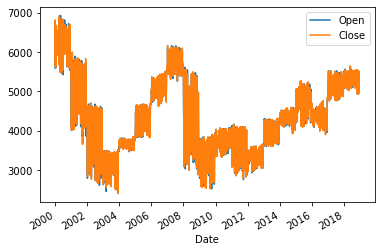

In [11]:
cac1_df[['Open','Close']].plot()
plt.show()

### 1.6. Split Dataset to train and test data

In [12]:
train_data, test_data = cac1_df[0:int(len(cac1_df)*0.7)], cac1_df[int(len(cac1_df)*0.7):]
training_data = train_data['Close'].values
test_data = test_data['Close'].values

### 1.7. Plot Training Data & Observation Data Trends

In [13]:
training_data1=pd.Series(training_data)

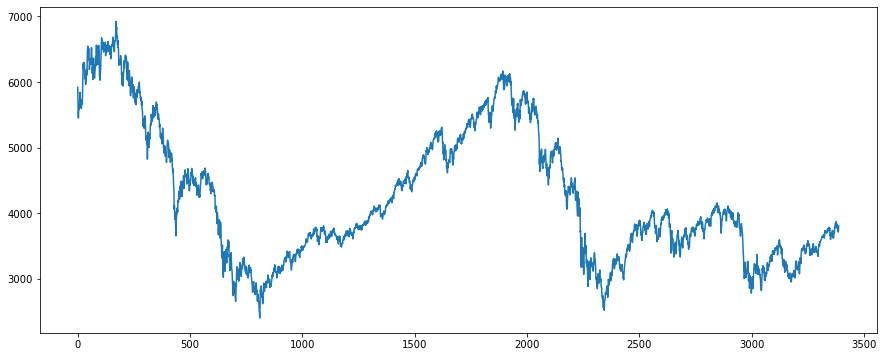

In [14]:
#plot training_data
training_data1.plot(figsize=(15, 6))
plt.show()

---

## Part 2. CAC 40 Stock Price Forecast with ARIMA

### 2.1. Make First Order Difference or Second Order Difference

#### 2.1.1. Make First Order Difference

In [15]:
cac1_df['First Order Difference'] = cac1_df['Close'] - cac1_df['Close'].shift(1)

#### 2.2.2. Plot the Training Data After the First Order Difference

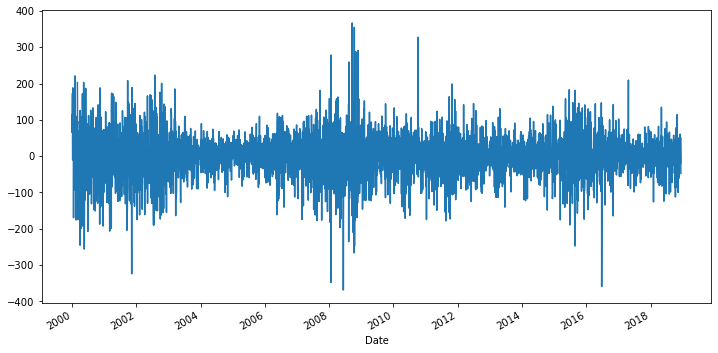

In [16]:
cac1_df['First Order Difference'].plot(figsize=(12, 6))
plt.show()

### 2.2. Draw ACF&PACF Chart and Select Hyperparameter q&p

#### 2.2.1. Draw ACF Chart and Chose Hyperparameter q in MA Model

In [17]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

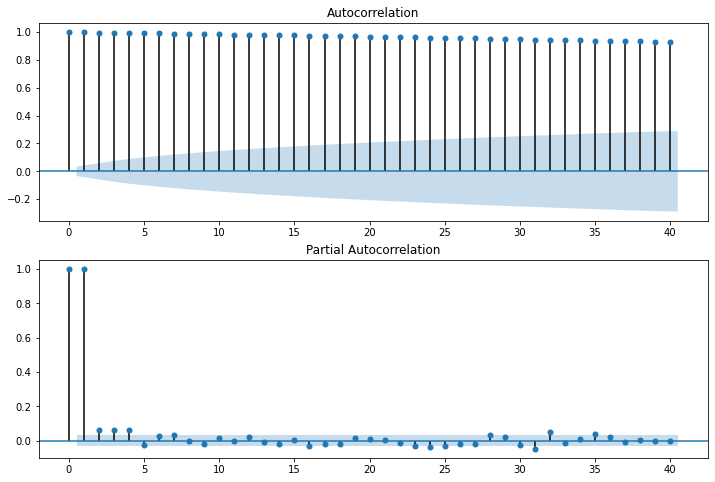

In [18]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(training_data1, lags=40, ax=ax1) # 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(training_data1, lags=40, ax=ax2)# , lags=40

#### 2.2.2. Draw PACF Chart and Chose Hyperparameter p in AR Model

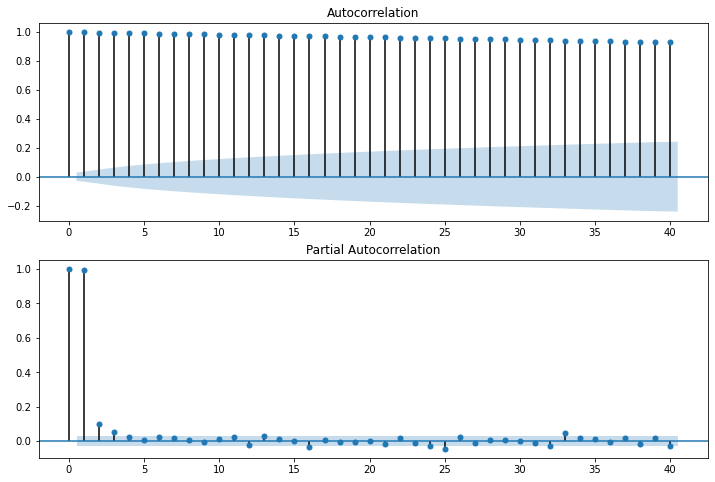

In [19]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(cac1_df.Open, lags=40, ax=ax1) # 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(cac1_df.Open, lags=40, ax=ax2)# , lags=40

### 2.3. Define then train the ARIMA Model

In [20]:
from statsmodels.tsa.arima_model import ARIMA
from pandas import DataFrame
from pandas import datetime

series = cac1_df['Close']
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:222: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:222: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4840
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -26541.028
Method:                       css-mle   S.D. of innovations             58.250
Date:                Wed, 13 Jan 2021   AIC                          53096.056
Time:                        11:27:53   BIC                          53141.448
Sample:                             1   HQIC                         53111.991
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.1774      0.728     -0.244      0.807      -1.604       1.249
ar.L1.D.Close    -0.0307      0.014     -2.136      0.033      -0.059      -0.003
ar.L2.D.Close    -0.0366      0.014     

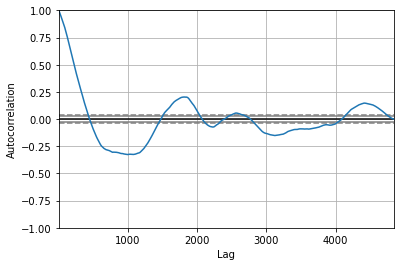

<Figure size 800x560 with 0 Axes>

In [21]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)
plt.figure(figsize=(10, 7), dpi=80)
plt.show()

### 2.4. Use ARIMA Model to Predict CAC 40 Stock Price After 2016 (Weekly Forecast)

#### 2.4.1. Use ARIMA Model to Predict

In [22]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

X = series.values
train_data, test_data = X[0:int(len(X)*0.7)], X[int(len(X)*0.7):]
history = [x for x in train_data]
predictions = list()
for t in range(len(test_data)):
    model = ARIMA(history, order=(5, 1, 0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_data[t]
    history.append(obs)

cac1_df['ARIMA'] = pd.DataFrame(predictions)

#### 2.4.2. Evaluation the arima predicted model using RMSE

In [23]:
error = mean_squared_error(test_data, predictions)
print('Test RMSE: %.3f' % error)

Test RMSE: 2401.412


#### 2.4.3. Plot the Predict Result

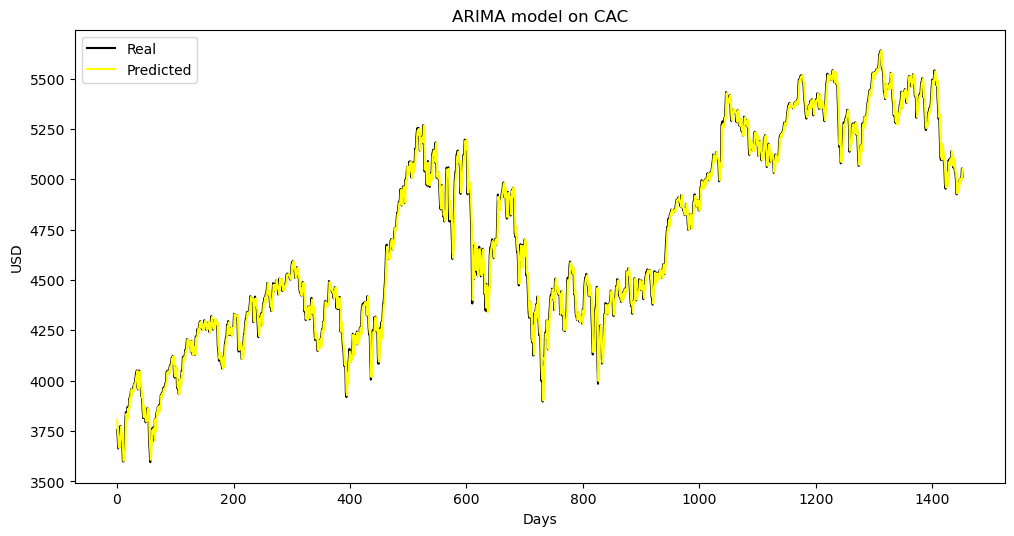

In [24]:
# Plot the predicted (from ARIMA) and real prices

plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test_data, color='black', label='Real')
plt.plot(predictions, color='yellow', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('ARIMA model on CAC')
plt.legend()
plt.show()

In [25]:
cac1_df.head(8)

,Open,High,Low,Close,Turnover,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,ARIMA,First Order Difference
Date,,,,,,,,,,,,,,,,,
2000-03-01,6024.38,6102.12,5901.77,5917.37,-,NaN,NaN,5917.370000,5917.370000,0.000000,NaN,NaN,NaN,5917.370000,58.1737,NaN,NaN
2000-04-01,5922.23,5925.07,5657.20,5672.02,-,NaN,NaN,5789.976731,5784.472083,-5.504647,NaN,NaN,NaN,5733.357500,55.7202,NaN,-245.35
2000-05-01,5521.83,5589.50,5461.59,5479.70,-,NaN,NaN,5678.497314,5665.519469,-12.977845,NaN,NaN,NaN,5557.748462,53.7970,NaN,-192.32
2000-06-01,5485.93,5530.26,5388.85,5450.11,-,NaN,NaN,5614.650201,5597.523118,-17.127084,NaN,NaN,NaN,5485.092500,53.5011,NaN,-29.59
2000-07-01,5423.88,5561.69,5423.88,5539.61,-,NaN,NaN,5597.248069,5581.788331,-15.459738,NaN,NaN,NaN,5521.587686,54.3961,NaN,89.50
2000-10-01,5625.82,5717.44,5616.98,5646.12,-,NaN,NaN,5607.036727,5597.424311,-9.612416,NaN,NaN,NaN,5604.723269,55.4612,NaN,106.51
2000-11-01,5726.51,5726.51,5571.99,5613.90,-,5616.975714,NaN,5608.257325,5601.100803,-7.156521,NaN,NaN,NaN,5610.843888,55.1390,NaN,-32.22
2000-12-01,5541.23,5628.73,5536.50,5582.50,-,5569.137143,NaN,5604.107181,5597.219102,-6.888079,NaN,NaN,NaN,5591.945082,54.8250,NaN,-31.40


In [26]:
print('Total dataset has {} samples, and {} features.'.format(cac1_df.shape[0], \
                                                              cac1_df.shape[1]))

Total dataset has 4841 samples, and 17 features.


---

## Part 3. CAC 40 Stock Price Forecast with LSTM [optional]

#### instead of using the ARIMA model use LSTM and do the same steps as ARIMA one. You may also need to add a normalisation step in the pre processing part

In [27]:
cac1_df.head()

,Open,High,Low,Close,Turnover,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,ARIMA,First Order Difference
Date,,,,,,,,,,,,,,,,,
2000-03-01,6024.38,6102.12,5901.77,5917.37,-,NaN,NaN,5917.370000,5917.370000,0.000000,NaN,NaN,NaN,5917.370000,58.1737,NaN,NaN
2000-04-01,5922.23,5925.07,5657.20,5672.02,-,NaN,NaN,5789.976731,5784.472083,-5.504647,NaN,NaN,NaN,5733.357500,55.7202,NaN,-245.35
2000-05-01,5521.83,5589.50,5461.59,5479.70,-,NaN,NaN,5678.497314,5665.519469,-12.977845,NaN,NaN,NaN,5557.748462,53.7970,NaN,-192.32
2000-06-01,5485.93,5530.26,5388.85,5450.11,-,NaN,NaN,5614.650201,5597.523118,-17.127084,NaN,NaN,NaN,5485.092500,53.5011,NaN,-29.59
2000-07-01,5423.88,5561.69,5423.88,5539.61,-,NaN,NaN,5597.248069,5581.788331,-15.459738,NaN,NaN,NaN,5521.587686,54.3961,NaN,89.50


In [28]:
print('Total dataset has {} samples, and {} features.'.format(cac1_df.shape[0], \
                                                              cac1_df.shape[1]))

Total dataset has 4841 samples, and 17 features.


**Following steps are done:**

**1.  Clean up the data-Remove any NAs**

**2.   Create a test, train and validate set**

**3.   Create train for Open**

**4.   Normalize data** 

**5.Create feature and label set**

**6. Train, test data and  check with validation set**

**7. Make a prediction**

**8. Based on this prediction find if the feature extraction method of LSTM works**



In [29]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Flatten

In [30]:
#creating test, train and validate trains
train, validate, test = np.split(cac1_df.sample(frac=1), [int(.6*len(cac1_df)), int(.8*len(cac1_df))])

**Split dataset into train,test and validate sets**

In [31]:
open_training = train.iloc[:, 1:2].values

**Normalize data:
The data is not normalized and the range for each column varies, especially Volume. Normalizing data helps the algorithm in converging i.e. to find local/ global minimum efficiently. I will use MinMaxScaler from Sci-kit Learn. Use a range to keep values similar for that much range**

**Keep a window for the length 2000 for your data between 50 and 500...since our length is slightly more than 2000 ill make it 60 to 450**

In [32]:
#normalise
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
open_training = scaler.fit_transform(open_training)
#convert to right shape
features_set_1 = []
labels_1 = []
for i in range(60,450): 
    features_set_1.append(open_training[i-60:i, 0])
    labels_1.append(open_training[i, 0])
    


In [33]:
features_set_1, labels_1 = np.array(features_set_1), np.array(labels_1)
features_set_1 = np.reshape(features_set_1, (features_set_1.shape[0], features_set_1.shape[1], 1))

In [34]:
#training it
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(features_set_1.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mean_absolute_error'])
model.fit(features_set_1, labels_1, epochs = 100, batch_size = 32,validation_data = (features_set_1, labels_1))


Epoch 1/100
13/13 [==============================] - 2s 119ms/step - loss: 0.0760 - mean_absolute_error: 0.2274 - val_loss: 0.0485 - val_mean_absolute_error: 0.1786
Epoch 2/100
13/13 [==============================] - 1s 63ms/step - loss: 0.0511 - mean_absolute_error: 0.1863 - val_loss: 0.0495 - val_mean_absolute_error: 0.1794
Epoch 3/100
13/13 [==============================] - 1s 63ms/step - loss: 0.0487 - mean_absolute_error: 0.1812 - val_loss: 0.0469 - val_mean_absolute_error: 0.1783
Epoch 4/100
13/13 [==============================] - 1s 59ms/step - loss: 0.0482 - mean_absolute_error: 0.1817 - val_loss: 0.0468 - val_mean_absolute_error: 0.1778
Epoch 5/100
13/13 [==============================] - 1s 59ms/step - loss: 0.0491 - mean_absolute_error: 0.1821 - val_loss: 0.0472 - val_mean_absolute_error: 0.1802
Epoch 6/100
13/13 [==============================] - 1s 59ms/step - loss: 0.0491 - mean_absolute_error: 0.1823 - val_loss: 0.0471 - val_mean_absolute_error: 0.1774
Epoch 7/100
13/

In [35]:
#TESTING THE MODEL
open_testing_processed = test.iloc[:, 1:2].values

In [36]:
#convert test data to right format
open_total = pd.concat((train['Open'], test['Open']), axis=0)

**Start predictions: Reshape, scale and then oredict the model**

In [37]:
test_inputs = open_total[len(open_total) - len(test) - 60:].values

In [38]:
#scaling data
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)

In [39]:
test_features = []
for i in range(60, 151):
    test_features.append(test_inputs[i-60:i, 0])

In [40]:
test_features = np.array(test_features)
test_features.shape
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))

In [41]:
#make predictions
predictions = model.predict(test_features)

In [42]:
predictions = scaler.inverse_transform(predictions)

**Plot the prediction model for the number of test days and train days**

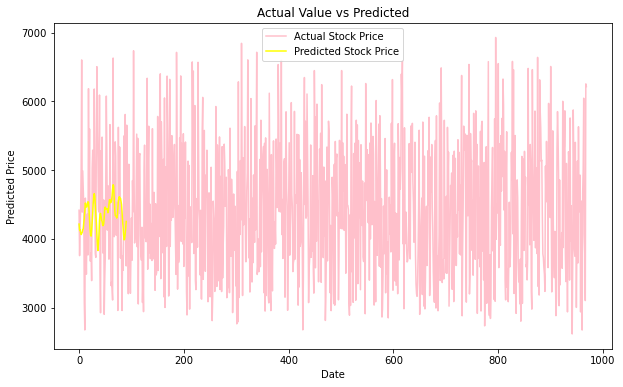

In [43]:
plt.figure(figsize=(10,6))
plt.plot(open_testing_processed, color='pink', label='Actual Stock Price')
plt.plot(predictions , color='yellow', label='Predicted Stock Price')
plt.title('Actual Value vs Predicted')
plt.xlabel('Date')
plt.ylabel('Predicted Price')
plt.legend()
plt.show()


>**This wasn't a great result with one feature so let's try using more features and then train them on LSTM model**

**USING 5 FEATURES :**

In [44]:
dataset = cac1_df[['Open','High','Low','Close','Turnover']]
dataset.head()

,Open,High,Low,Close,Turnover
Date,,,,,
2000-03-01,6024.38,6102.12,5901.77,5917.37,-
2000-04-01,5922.23,5925.07,5657.20,5672.02,-
2000-05-01,5521.83,5589.50,5461.59,5479.70,-
2000-06-01,5485.93,5530.26,5388.85,5450.11,-
2000-07-01,5423.88,5561.69,5423.88,5539.61,-


In [45]:
# FUNCTION TO CREATE 1D DATA INTO TIME SERIES DATASET
def new_dataset(dataset, step_size):
	data_X, data_Y = [], []
	for i in range(len(dataset)-step_size-1):
		a = dataset[i:(i+step_size), 0]
		data_X.append(a)
		data_Y.append(dataset[i + step_size, 0])
	return np.array(data_X), np.array(data_Y)

In [46]:
# IMPORTING IMPORTANT LIBRARIES
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM

In [47]:
# FOR REPRODUCIBILITY
np.random.seed(7)

In [48]:
# IMPORTING DATASET 
dataset = dataset.reindex(index = dataset.index[::-1])
# CREATING OWN INDEX FOR FLEXIBILITY
obs = np.arange(1, len(dataset) + 1, 1)
# TAKING DIFFERENT INDICATORS FOR PREDICTION
OHLC_avg = dataset.mean(axis = 1)
HLC_avg = dataset[['High', 'Low', 'Close']].mean(axis = 1)
close_val = dataset[['Close']]

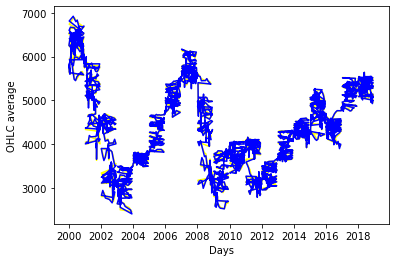

In [49]:
# PLOTTING All INDICATORS IN PLOT
plt.plot(OHLC_avg, 'yellow', label = 'OHLC avg')
plt.plot(close_val, 'blue', label = 'Closing price')
plt.xlabel('Days')
plt.ylabel('OHLC average')
plt.show()


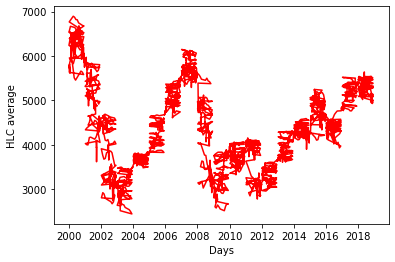

In [50]:
plt.plot(HLC_avg, 'red', label = 'HLC avg')
plt.xlabel('Days')
plt.ylabel('HLC average')
plt.show()

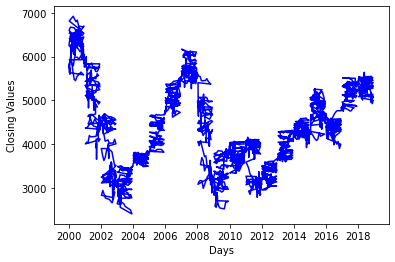

In [51]:
plt.plot(close_val, 'blue', label = 'Closing price')
plt.xlabel('Days')
plt.ylabel('Closing Values')
plt.show()

In [52]:
# PREPARATION OF TIME SERIES DATASE
OHLC_avg = np.reshape(OHLC_avg.values, (len(OHLC_avg),1)) 
scaler = MinMaxScaler(feature_range=(0, 1))
OHLC_avg = scaler.fit_transform(OHLC_avg)
# TRAIN-TEST SPLIT
train_OHLC = int(len(OHLC_avg) * 0.75)
test_OHLC = len(OHLC_avg) - train_OHLC
train_OHLC, test_OHLC = OHLC_avg[0:train_OHLC,:], OHLC_avg[train_OHLC:len(OHLC_avg),:]
# TIME-SERIES DATASET (FOR TIME T, VALUES FOR TIME T+1)
trainX, trainY = new_dataset(train_OHLC, 1)
testX, testY = new_dataset(test_OHLC, 1)
# RESHAPING TRAIN AND TEST DATA
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
step_size = 1


In [53]:
# LSTM MODEL
model = Sequential()
model.add(LSTM(32, input_shape=(1, step_size), return_sequences = True))
model.add(LSTM(16))
model.add(Dense(1))
model.add(Activation('linear'))

In [54]:
# MODEL COMPILING AND TRAINING
model.compile(loss='mean_squared_error', optimizer='adagrad',metrics = ['mae']) # Try mae, adam, adagrad and compare!!!
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2)

Epoch 1/50
3628/3628 - 6s - loss: 0.1045 - mae: 0.2740
Epoch 2/50
3628/3628 - 6s - loss: 0.0431 - mae: 0.1673
Epoch 3/50
3628/3628 - 6s - loss: 0.0297 - mae: 0.1422
Epoch 4/50
3628/3628 - 6s - loss: 0.0265 - mae: 0.1359
Epoch 5/50
3628/3628 - 6s - loss: 0.0255 - mae: 0.1337
Epoch 6/50
3628/3628 - 6s - loss: 0.0249 - mae: 0.1323
Epoch 7/50
3628/3628 - 6s - loss: 0.0244 - mae: 0.1309
Epoch 8/50
3628/3628 - 6s - loss: 0.0239 - mae: 0.1296
Epoch 9/50
3628/3628 - 6s - loss: 0.0234 - mae: 0.1283
Epoch 10/50
3628/3628 - 6s - loss: 0.0229 - mae: 0.1269
Epoch 11/50
3628/3628 - 6s - loss: 0.0224 - mae: 0.1256
Epoch 12/50
3628/3628 - 6s - loss: 0.0219 - mae: 0.1242
Epoch 13/50
3628/3628 - 6s - loss: 0.0214 - mae: 0.1228
Epoch 14/50
3628/3628 - 6s - loss: 0.0209 - mae: 0.1214
Epoch 15/50
3628/3628 - 6s - loss: 0.0204 - mae: 0.1199
Epoch 16/50
3628/3628 - 6s - loss: 0.0199 - mae: 0.1185
Epoch 17/50
3628/3628 - 6s - loss: 0.0194 - mae: 0.1170
Epoch 18/50
3628/3628 - 6s - loss: 0.0189 - mae: 0.1155
E

In [55]:
mae = model.evaluate(testX, testY, batch_size=16)
print('Mean Absolute Error for Y:', mae)

76/76 [==============================] - 0s 1ms/step - loss: 0.0111 - mae: 0.0923
Mean Absolute Error for Y: [0.011081618256866932, 0.09226291626691818]


In [56]:
# PREDICTION
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [57]:
# DE-NORMALIZING FOR PLOTTING
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# TRAINING RMSE
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train RMSE: %.2f' % (trainScore))

Train RMSE: 297.61


In [58]:
# TEST RMSE
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test RMSE: %.2f' % (testScore))

Test RMSE: 466.44


In [59]:
# CREATING SIMILAR DATASET TO PLOT TRAINING PREDICTIONS
trainPredictPlot = np.empty_like(OHLC_avg)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[step_size:len(trainPredict)+step_size, :] = trainPredict
# CREATING SIMILAR DATASSET TO PLOT TEST PREDICTIONS
testPredictPlot = np.empty_like(OHLC_avg)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(step_size*2)+1:len(OHLC_avg)-1, :] = testPredict

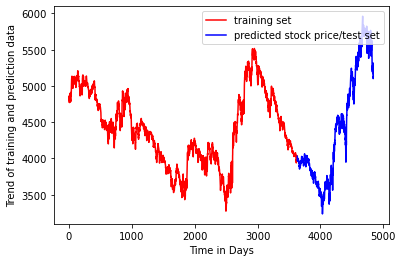

In [60]:
# PLOT OF MAIN OHLC VALUES, TRAIN PREDICTIONS AND TEST PREDICTIONS
plt.plot(trainPredictPlot, 'r', label = 'training set')
plt.plot(testPredictPlot, 'b', label = 'predicted stock price/test set')
plt.legend(loc = 'upper right')
plt.xlabel('Time in Days')
plt.ylabel('Trend of training and prediction data')
plt.show()


In [61]:
# PREDICT FUTURE VALUES
last_val = testPredict[-1]
last_val_scaled = last_val/last_val
next_val = model.predict(np.reshape(last_val_scaled, (1,1,1)))
print("Last Day Value:", np.asscalar(last_val))
print("Next Day Value:", np.asscalar(last_val*next_val))
# print np.append(last_val, next_val)


Last Day Value: 5131.7021484375
Next Day Value: 4058.545654296875
